In [129]:
import numpy as np
import math
from pathlib import Path
import struct
import matplotlib.pyplot as plt

In [130]:
# 定义激活函数
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp=np.exp(x-x.max())
    return exp/exp.sum()

In [131]:
# 定义参数的初始值，b0、b1都取0，w1取[-sqrt(6/(28*28+10)),sqrt(6/28*28+10)]
# 定义维度，输入层有28*28个，输出层有10个 
dimensions=[28*28,10] 
activation=[tanh,softmax]
distribution=[
    {'b':[0,0]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])),math.sqrt(6/(dimensions[0]+dimensions[1]))]}
] 

In [132]:
# 初始化参数
# random生成（0,1）的随机数，要让它生成参数定义的区间
def init_parameters_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]
# w1是(784,10)维
def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [133]:
parameters=init_parameters()

In [134]:
# 搭建神经网络（现在参数为初始值）
def predict(img,parameters):
    l0_in=img+parameters[0]['b']
    l0_out=activation[0](l0_in)
    l1_in=np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
    l1_out=activation[1](l1_in)
    return l1_out

In [135]:
# 数据集来源：http://yann.lecun.com/exdb/mnist/


In [136]:
# 设置数据路径
dataset_path=Path('./data')
train_img_path=dataset_path/'train-images.idx3-ubyte'
train_lab_path=dataset_path/'train-labels.idx1-ubyte'
test_img_path=dataset_path/'t10k-images.idx3-ubyte'
test_lab_path=dataset_path/'t10k-labels.idx1-ubyte'

In [137]:
# 读取数据
train_num=50000
valid_num=10000
test_num=10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)
    train_img=tmp_img[:train_num]
    valid_img=tmp_img[train_num:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)
    
with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab=np.fromfile(f,dtype=np.uint8)
    train_lab=tmp_lab[:train_num]
    valid_lab=tmp_lab[train_num:]
    
with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_lab=np.fromfile(f,dtype=np.uint8)

In [138]:
# 显示数据集图片
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    print('label:{}'.format(train_lab[index]))
    
def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    print('label:{}'.format(valid_lab[index]))
    
def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    print('label:{}'.format(test_lab[index]))

label:0


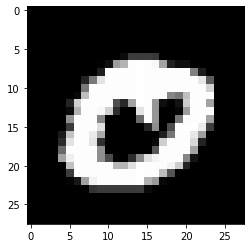

In [139]:
show_train(np.random.randint(50000))

label:8


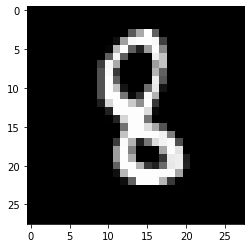

In [206]:
show_valid(np.random.randint(valid_num))

label:25


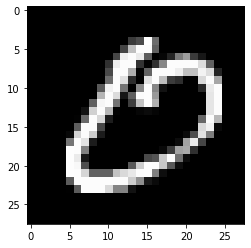

In [211]:
show_test(np.random.randint(10000))

In [ ]:
# 梯度下降

In [156]:
differential={softmax:d_softmax,tanh:d_tanh}

def d_softmax(data):
    sm=softmax(data)
    return np.diag(sm)-np.outer(sm,sm)
               
def d_tanh(data):
    return 1/(np.cosh(data))**2
               

In [157]:
h=0.0001
func=softmax
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
    # print(derivative[i]-(value2-value1)/h)

In [158]:
h=0.000001
func=tanh
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
    # print(derivative[i]-(value2-value1)/h)

In [164]:
onehot=np.identity(dimensions[-1])

def sqr_loss(img,lab,parameters):
    y_pred=predict(img,parameters)
    y=onehot[lab]
    diff=y-y_pred
    return np.dot(diff,diff)

def grad_parameters(img,lab,parameters):
    l0_in=img+parameters[0]['b']
    l0_out=activation[0](l0_in)
    l1_in=np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
    l1_out=activation[1](l1_in)
    
    diff=onehot[lab]-l1_out
    act1=np.dot(differential[activation[1]](l1_in),diff)
    
    grad_b1=-2*act1
    grad_w1=-2*np.outer(l0_out,act1)
    grad_b0=-2*differential[activation[0]](l0_in)*np.dot(parameters[1]['w'],act1)
    
    return {'w1':grad_w1,'b1':grad_b1,'b0':grad_b0}

In [ ]:
# b1
for i in range(10):
    img_i